# Natural Language Processing for the Fake News Challenge

## Main Imports

In [1]:
import re
import torch
import string
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from joblib import dump, load
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

!pip install transformers
import transformers

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 2.3MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 54.2MB/s 
     |████████████████████████████████| 901kB 55.9MB/s 


## Set up the data for preprocessing
### Load the data

In [2]:
main_path = '/content/drive/My Drive/University Work/Year 4/Natural Language Processing/'
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = main_path + data_folder_name +'/'+ train_body_filename 
train_stance_path = main_path + data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

### Preprocessing by removing stopwords and punctuation and applying stemming

In [3]:
def preprocess(text):

    text = nltk.tokenize.word_tokenize(text)
    text = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
    text = (" ").join(text)

    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    ps = nltk.stem.PorterStemmer()
    text = nltk.tokenize.word_tokenize(text)

    text = [ps.stem(word) for word in text]
    text = (" ").join(text)

    return text

In [4]:
body_data['articleBody'] = body_data['articleBody'].apply(lambda x: preprocess(x))
stance_data['Headline'] = stance_data['Headline'].apply(lambda x: preprocess(x))

### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [5]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 0, 1)
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
13156,782,american photojournalist jame wright foley beh...,fear journalist jame wright foley behead islam...,discuss,1
40242,2118,On day michael brown buri ferguson man releas ...,audio gunfir michael brown case authent app co...,discuss,1
10000,615,ehoh A 19yearold student claim ye giggli babi ...,kim jongun ban name kim jongun,unrelated,0
3174,186,the sound 10 11 shot gun ferguson Mo polic off...,kim Yo jong kim jongun ’ sister take control n...,unrelated,0
16856,1004,cnn A woman held lebanes author wife isi leade...,iraqi offici dismiss ‘ unfound ’ report that i...,unrelated,0
26459,1489,the islam state killer jihadi john identifi mo...,jihadi john ident reveal moham emwazi live,discuss,1
36631,1949,there middl field bake sun cach grenad rocket ...,pentagon 1 weapon bundl seiz milit,agree,1
46579,2385,congression republican push “ isi At border ” ...,6 hidden mass grave may hold miss mexican student,unrelated,0
38265,2039,while laptop sale continu drop appl s macbook ...,congressman ‘ At least 10 isi fighter ’ caught...,unrelated,0
20485,1215,We need best actor board certain age rang ’ ch...,christian bale set play steve job forthcom bio...,agree,1


### Splitting the dataset into train and validation sets

In [6]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
24516,israel deni caus gaza flood open dam,israel reject alleg govern offici gaza strip a...
44016,iraq say arrest woman Is not the wife isi lead...,want islam state group chief abu bakr albaghda...
24619,predat drone reportedli sight circl raqqa syria,durex deni rumor ‘ pumpkin spice ’ flavor cond...
14108,I abort babi boy,the white hous fenc jumper last week somehow m...
37101,cnn play alleg record michael brown shoot,the world health organis investig report isi m...
33194,wildest appl watch rumor yet 100000 app launch,one passeng dull intern airport outsid washing...
39088,kim jongun reli ‘ cobra wine ’ problem trouser...,A touch tribut victim charli hebdo shoot post ...
21977,audio gunfir michael brown case authent app co...,A new rumor make round today claim recent trip...
8255,man chop peni girlfriend told good bed,A jilt lover macedonia chop peni girlfriend to...
41430,thi selfless homeless man receiv 100 doe nt sp...,elect offici activist new york react posit cit...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [7]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [9]:
max_features = 200

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=max_features, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=max_features, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
tfidf_train = preprocessor.fit_transform(X_train).todense()
tfidf_val = preprocessor.transform(X_val).todense()
print('Train size: ', tfidf_train.shape)
print('Val size: ', tfidf_val.shape)

Train size:  (39977, 400)
Val size:  (9995, 400)


## Evaluation Metrics

### Confusion Matrix

In [10]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [11]:
# ROC Curve
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display Classification Accuracies over results and plot Confusion Matrix and ROC Curve results

In [13]:
def display_results(y_pred, y_val):

    # print classification report and plot confusion matrix and ROC curve
    print(metrics.classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)
    plot_roc_curve(y_val, y_pred)

## Machine Learning Models

### Train Random Forest (RF) Classifier using TF-IDF Features and display results

In [16]:
tfidf_RF_model = RandomForestClassifier(random_state=0).fit(tfidf_train, y_train)
tfidf_RF_model.score(tfidf_val, y_val)

0.9651825912956479

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7228
           1       0.96      0.91      0.94      2767

    accuracy                           0.97      9995
   macro avg       0.96      0.95      0.96      9995
weighted avg       0.97      0.97      0.96      9995



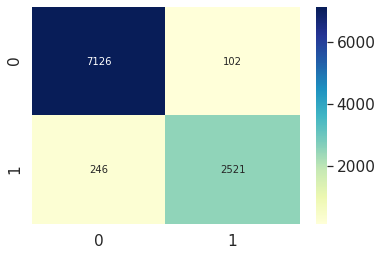

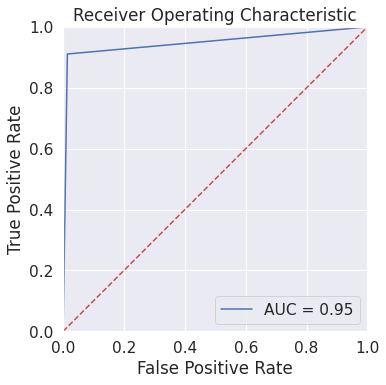

In [17]:
y_pred = tfidf_RF_model.predict(tfidf_val)
display_results(y_pred, y_val)

# Tokenisation with BERT

### Load the model and tokeniser

In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Embedding Retrieval

In [ ]:
def get_bert_embeddings(bert_model, data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls_token_embeddings = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings

    for i in range(batch_size, data.shape[0] + batch_size, batch_size):
    
        if i % 100 == 0:
            print("Batch", i)

        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            word_embeddings = bert_model(tokenized_text)
        cls_token_embeddings = get_cls_token_embeddings(word_embeddings)

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = cls_token_embeddings
        else:
            bert_embeddings = torch.cat((bert_embeddings, cls_token_embeddings), 0)

        # clear cache and GPU memory
        del word_embeddings
        torch.cuda.empty_cache()

    return bert_embeddings

In [ ]:
device = torch.device("cuda")
bert_model = bert_model.to(device)
batch_size = 256

print("Training Set")
bert_train = get_bert_embeddings(bert_model, X_train, batch_size)
torch.save(bert_train, main_path + 'bert_train.pt')

print("Testing Set")
bert_val = get_bert_embeddings(bert_model, X_val, batch_size)
torch.save(bert_val, main_path + 'bert_val.pt')

Training Set
Batch 6400
Batch 12800
Batch 19200
Batch 25600
Batch 32000
Batch 38400
Testing Set
Batch 6400


In [18]:
bert_train = torch.load(main_path + 'bert_train.pt')
bert_val = torch.load(main_path + 'bert_val.pt')

### Train Random Forest (RF) Classifier using BERT Embeddings and display results

In [19]:
bert_RF_model = RandomForestClassifier(random_state=0).fit(bert_train.cpu(), y_train)
bert_RF_model.score(bert_val.cpu(), y_val)

0.8963481740870435

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7228
           1       0.93      0.68      0.78      2767

    accuracy                           0.90      9995
   macro avg       0.91      0.83      0.86      9995
weighted avg       0.90      0.90      0.89      9995



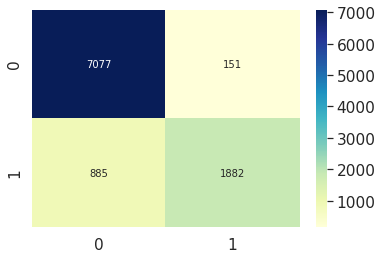

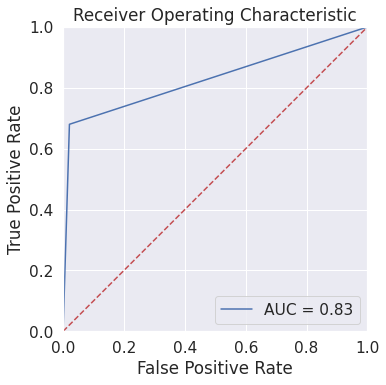

In [21]:
y_pred = bert_RF_model.predict(bert_val.cpu())
display_results(y_pred, y_val)

## Deep Learning Models

### Train a Multi-Layer Perceptron (MLP) on TF-IDF Embeddings

#### Generate batches for input to MLP

In [ ]:
def batch_generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    index = np.arange(np.shape(y_data)[0])
    counter = 0

    while 1:

        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:]
        y_batch = y_data[index_batch]

        counter += 1
        yield X_batch, y_batch
        
        if (counter > number_of_batches):
            counter = 0

#### Define the MLP

In [ ]:
MLP = Sequential()
MLP.add(Dense(64, activation='relu', input_dim=400))
MLP.add(Dense(64, activation='relu'))
MLP.add(Dense(1, activation='sigmoid'))
MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
print(MLP.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                25664     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 29,889
Trainable params: 29,889
Non-trainable params: 0
_________________________________________________________________
None


#### Train the MLP

In [ ]:
batch_size = 32
MLP.fit(batch_generator(tfidf_train, y_train, batch_size),
          epochs=5, validation_data=(tfidf_val, y_val),
          steps_per_epoch=tfidf_train.shape[0]/batch_size)

Epoch 1/5
1249/1249 [==============================] - 4s 3ms/step - loss: 0.4523 - accuracy: 0.7991 - val_loss: 0.1372 - val_accuracy: 0.9454
Epoch 2/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0978 - accuracy: 0.9635 - val_loss: 0.0963 - val_accuracy: 0.9616
Epoch 3/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0523 - accuracy: 0.9818 - val_loss: 0.0882 - val_accuracy: 0.9668
Epoch 4/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.0884 - val_accuracy: 0.9688
Epoch 5/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0238 - accuracy: 0.9930 - val_loss: 0.0962 - val_accuracy: 0.9698


### Display Results of MLP on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7228
           1       0.92      0.97      0.95      2767

    accuracy                           0.97      9995
   macro avg       0.96      0.97      0.96      9995
weighted avg       0.97      0.97      0.97      9995



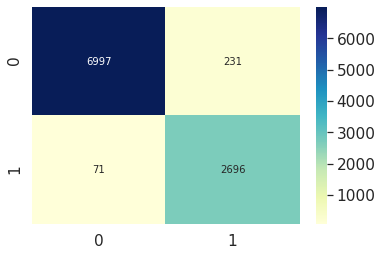

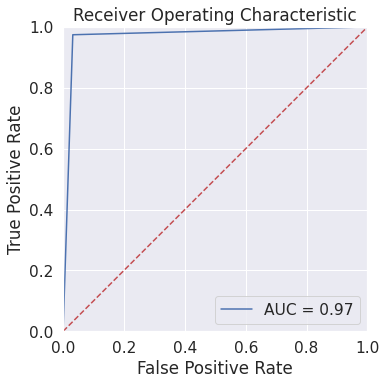

In [ ]:
y_pred = (MLP.predict(tfidf_val) > 0.5).astype("int32")
display_results(y_pred, y_val)